# 09A. Global optimization: MCMC optimization methods

### Mingyang Lu

### 3/28/2024

# Inefficient sampling 

Metropolis-Hastings algorithm is very powerful in sampling a probability distribution. However, it could be inefficient in some situations. For example, for a physical system in equilibrium, the sampling of the Boltzmann distribution becomes inefficient at low temperatures $T$. This is because the acceptance rate

$$a  = min(1, \frac{P(x')}{P(x)}) = min(1, e^{-(E_{x'} - E_x)/T}) \tag{1}$$

is extremely low for small $T$. When the system's energy has multiple local minima, MCMC sampling at a low temperature would sample one of the energy basins well, but it is very hard to allow transitions and sample the other energy basins. On the other hand, MCMC sampling at a high temperature would allow transitions across energy barriers but ineffective in sampling certain energy minima. Here, we will discuss a few MCMC algorithms for enhanced sampling and global minimization.

# Himmelblau's function

Here, we use the Himmelblau's function as an example. The Himmelblau's function is defined by

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2. \tag{2}$$
As illustrated by the contour map of $f(x,y)$, the Himmelblau's function has four well-separated local minima. All of the minima have $f(x,y) = 0$. The function has been used to evaluate the performance of optimization methods.

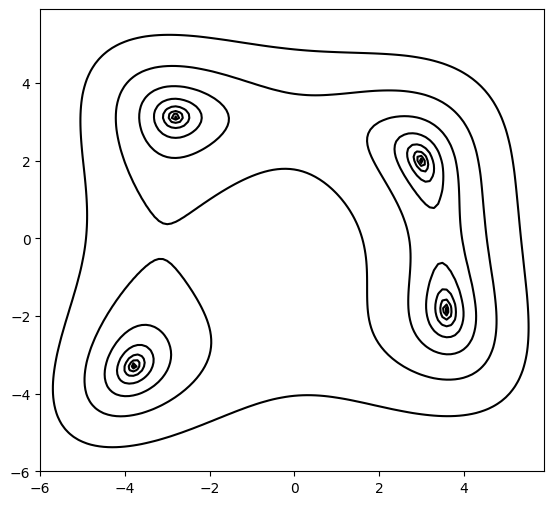

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f_Himmelblau(x):
    f1 = x[0]**2 + x[1] - 11
    f2 = x[0] + x[1]**2 - 7
    return f1**2 + f2**2

x_all = np.arange(-6, 6, 0.1)
y_all = np.arange(-6, 6, 0.1)
data = np.array(np.meshgrid(x_all, y_all)).T.reshape(-1, 2)
z_all = np.apply_along_axis(f_Himmelblau, 1, data)

fig = plt.figure(figsize=(6.5, 6))
ax = fig.add_subplot(111)
contour = ax.contour(data[:, 0].reshape(len(x_all), -1),
                     data[:, 1].reshape(len(y_all), -1),
                     z_all.reshape(len(x_all), -1),
                     levels=10**(np.arange(-2, 3, 0.5)),
                     colors='black')
plt.show()

# Sampling by the Metropolis-Hastings algorithm

We can use the standard Metropolis-Hastings algorithm (MH) to sample the landscape of $f$. The Metropolis-Hastings algorithm function *mh* is slightly modified from a previous version, so that it can be used later in one of the MCMC enhanced sampling methods. 


In [2]:
def mh(n, func, x0, nstep, dx_max, temp, ifprint=False):
    # n: number of variables
    # func: function to optimize func(x); x: vector of size n
    # x0: initial condition, vector of size n
    # nstep: number of steps
    # dx_max: maximum step size (chosen from a uniform distribution)
    # temp: temperature 
    # ifprint: logical, print messages (acceptance rate)
    x = np.zeros((nstep + 1, len(x0)))
    e = np.zeros(nstep + 1)

    x[0] = x0
    e[0] = func(x[0])
    num_accept = 0

    for i in range(nstep):
        dx = np.random.uniform(low=-dx_max, high=dx_max, size=n)
        xnew = x[i] + dx
        enew = func(xnew)
        de = enew - e[i]
        if de < 0 or np.random.rand() < np.exp(-de / temp):
            x[i + 1] = xnew
            e[i + 1] = enew
            num_accept += 1
        else:
            x[i + 1] = x[i]
            e[i + 1] = e[i]

    rate = num_accept / nstep
    if ifprint:
        print("Acceptance rate", rate)
    return {"x": x, "e": e, "rate": rate}

For the following four temperatures $T=$ 1, 10, 30, and 50, the higher the $T$, more spaces around multiple local minima can then be sampled. At the lowest $T$, the MH sampling is trapped in a single minimum.

/var/folders/jl/4jg34fpx0252dr9hw47z_16m0000gn/T/ipykernel_31310/661969768.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Acceptance rate 0.1653
Acceptance rate 0.5703
Acceptance rate 0.8003
Acceptance rate 0.8393


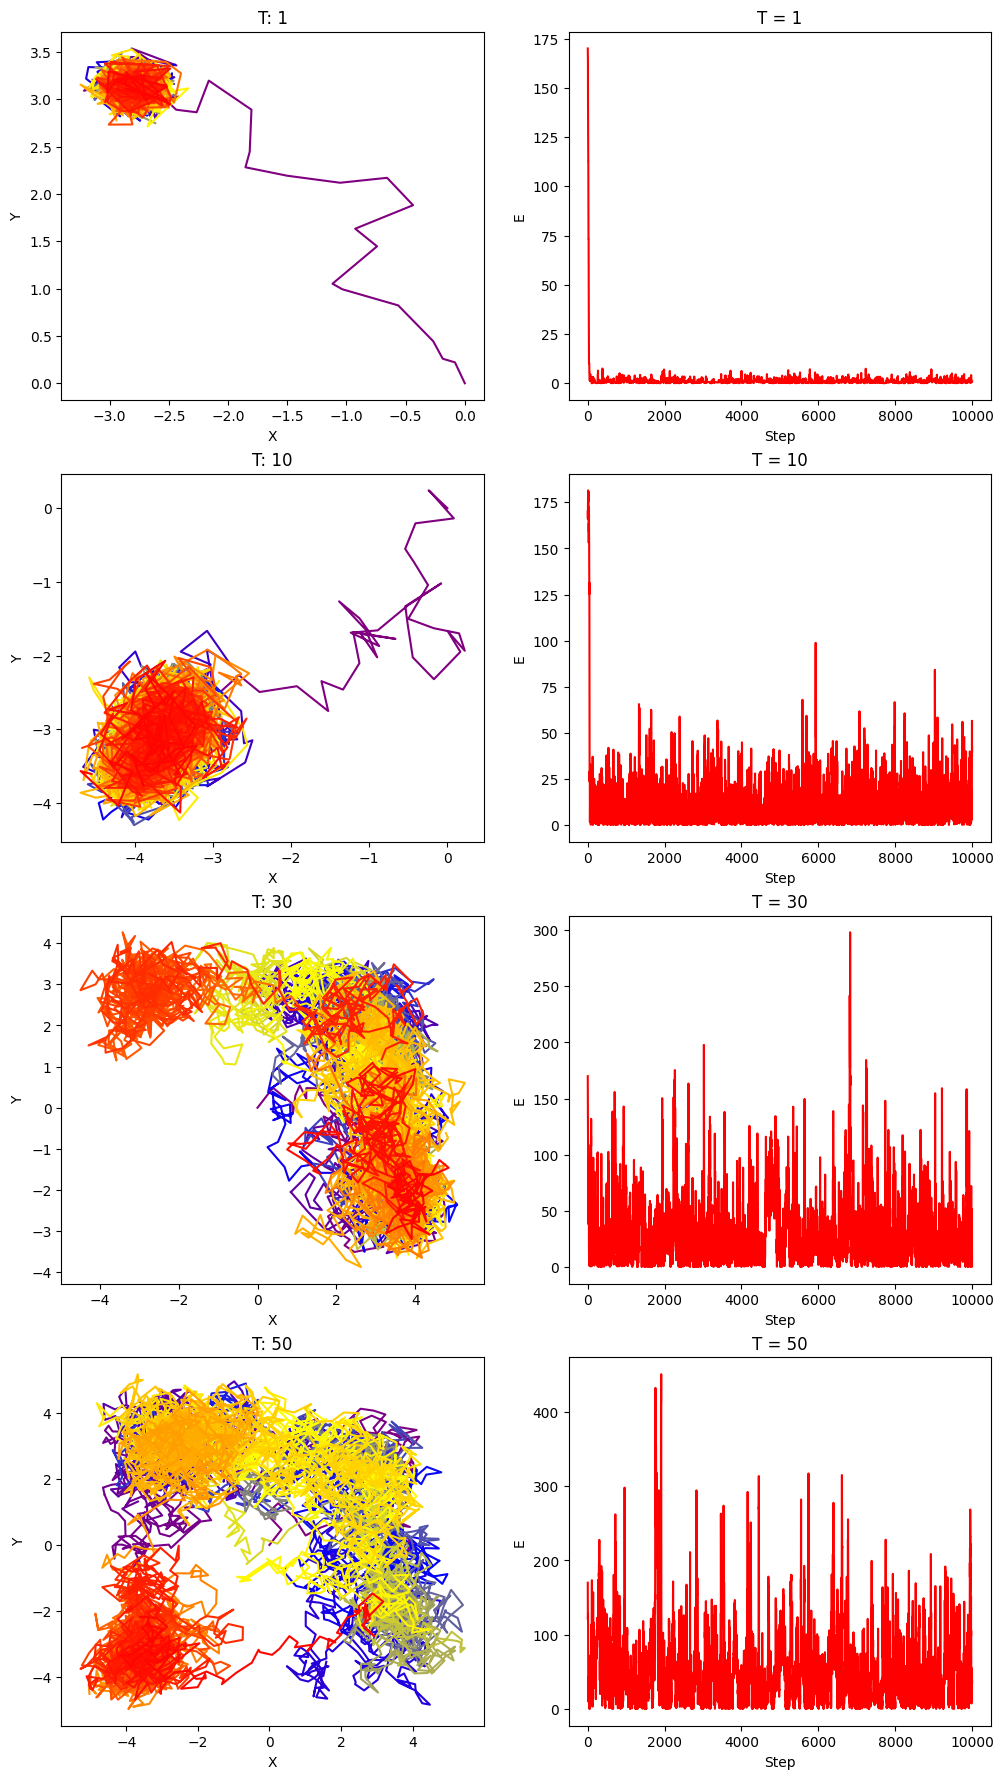

In [3]:
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

def temp_all():
    return [1, 10, 30, 50]

np.random.seed(1)
nstep = 10**4

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 8 subplots, with 2 subplots in each row
fig, axes = plt.subplots(4, 2, figsize=(12, 22))

temp_vals = temp_all()
for i in range(len(temp_vals)):
    results_mh = mh(n=2, func=f_Himmelblau, x0=np.zeros(2), nstep=nstep, dx_max=0.5,
                     temp=temp_vals[i], ifprint=True)

    for j in range(nseg):
        axes[i, 0].plot(results_mh["x"][j*neach:(j+1)*neach,0], results_mh["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[i, 0].set_xlabel('X')
    axes[i, 0].set_ylabel('Y')
    axes[i, 0].set_title(f'T: {temp_vals[i]}')

    axes[i, 1].plot(range(nstep + 1), results_mh["e"], color='r')
    axes[i, 1].set_xlabel('Step')
    axes[i, 1].set_ylabel('E')
    axes[i, 1].set_title(f'T = {temp_vals[i]}')
    
plt.show()

# Simulated annealing

A powerful yet surprisingly simple global optimization method is to perform the same Metropolis-Hastings sampling of the Boltzmann distributions but with a decreasing temperature. We typically start with a sufficiently high temperature to allow the sampling of all basins and end with a temperature at (or close to) zero to reach to a local minimum. The method is called simulated annealing (SA). Although the SA method does not guarantee to obtain the global minimum, many runs of the SA sampling/simulations would increase the chance to sample the global minimum. SA has been widely used as a global optimization algorithm due to its simplicity, easy implementation, and effectiveness in many situations. 

There are different temperature updating schemes. Below shows one way that linearly decreases the temperature.

In [4]:
def sa_linear(n, func, nstep, dx_max, temp_max, scaling, ifprint=False):
    # n: number of variables
    # func: function to optimize func(x); x: vector of size n
    # nstep: number of steps
    # dx_max: maximum step size (chosen from a uniform distribution)
    # temp_max: maximum (initial) temperature 
    # scaling: temperature scaling factor
    # ifprint: logical, print messages (acceptance rate)
    x = np.zeros((nstep+1, n))
    e = np.zeros(nstep+1)
    t = np.linspace(temp_max, 0, num=nstep+1)

    x[0, :] = np.zeros(n)
    e[0] = func(x[0, :])
    num_accept = 0
    
    for i in range(nstep):
        dx = np.random.uniform(low=-dx_max, high=dx_max, size=n)
        xnew = x[i, :] + dx
        enew = func(xnew)
        de = enew - e[i]
        if de < 0 or np.random.rand() < np.exp(-de/t[i]):
            x[i+1, :] = xnew
            e[i+1] = enew
            num_accept += 1
        else:
            x[i+1, :] = x[i, :]
            e[i+1] = e[i]
    
    if ifprint:
        print("Acceptance rate:", num_accept/nstep)
    
    return {'x': x, 'e': e, 't': t}

Acceptance rate: 0.7126


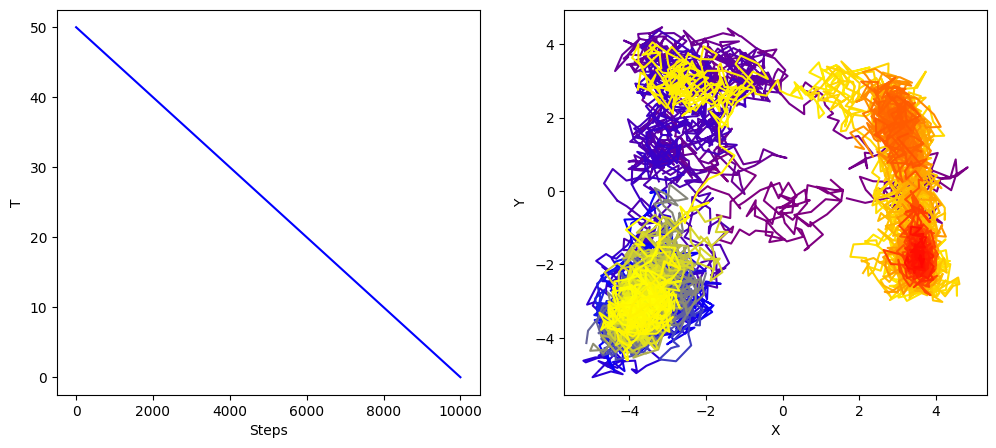

Final e: 0.038681350190294256
Final xy: [ 3.55744972 -1.83179219]


In [5]:
np.random.seed(1)
nstep = 10**4
results_sa = sa_linear(n=2, func=f_Himmelblau, nstep=nstep, dx_max=0.5,
                       temp_max=50, scaling=0.99, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(results_sa['t'], color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('T')

for j in range(nseg):
    axes[1].plot(results_sa["x"][j*neach:(j+1)*neach,0], results_sa["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

final_e = results_sa['e'][-1]
final_xy = results_sa['x'][-1]

print("Final e:", final_e)
print("Final xy:", final_xy)

Another common temperature updating scheme is based on a geometric scaling. During each iteration, the current temperature is scaled by a factor smaller but very close to 1 (*e.g.*, 0.999, see the argument *scaling* in the following SA implementation). The geometric scaling allows the global optimization to converge faster.

In [6]:
def sa_geometric(n, func, nstep, dx_max, temp_max, scaling, ifprint=False):
    # n: number of variables
    # func: function to optimize func(x); x: vector of size n
    # nstep: number of steps
    # dx_max: maximum step size (chosen from a uniform distribution)
    # temp_max: maximum (initial) temperature 
    # scaling: temperature scaling factor
    # ifprint: logical, print messages (acceptance rate)
    x = np.zeros((nstep+1, n))
    e = np.zeros(nstep+1)
    t = temp_max * (scaling ** np.arange(nstep+1))

    x[0, :] = np.zeros(n)
    e[0] = func(x[0, :])
    num_accept = 0
    
    for i in range(nstep):
        dx = np.random.uniform(low=-dx_max, high=dx_max, size=n)
        xnew = x[i, :] + dx
        enew = func(xnew)
        de = enew - e[i]
        if de < 0 or np.random.rand() < np.exp(-de/t[i]):
            x[i+1, :] = xnew
            e[i+1] = enew
            num_accept += 1
        else:
            x[i+1, :] = x[i, :]
            e[i+1] = e[i]
    
    if ifprint:
        print("Acceptance rate:", num_accept/nstep)
    
    return {'x': x, 'e': e, 't': t}

Acceptance rate: 0.2537


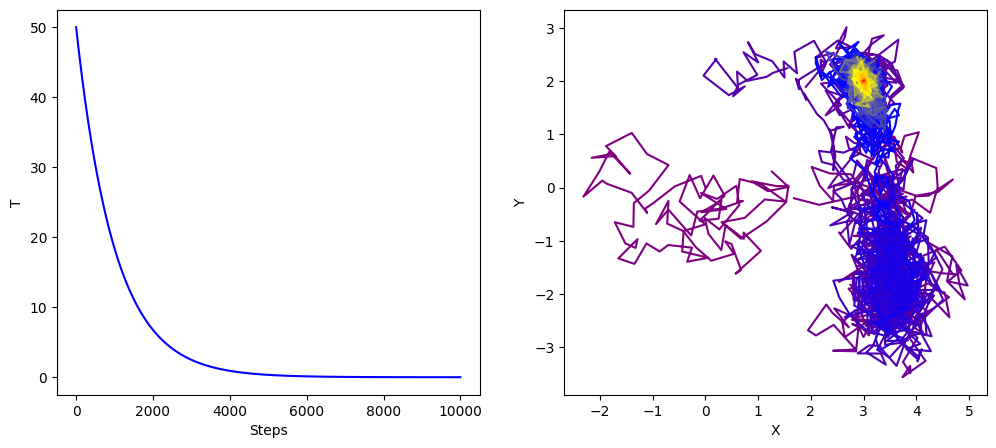

Final e: 0.006838593573513372
Final xy: [2.98657011 1.99930631]


In [7]:
np.random.seed(1)
nstep = 10**4
results_sa = sa_geometric(n=2, func=f_Himmelblau, nstep=nstep, dx_max=0.5,
                       temp_max=50, scaling=0.999, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(results_sa['t'], color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('T')

for j in range(nseg):
    axes[1].plot(results_sa["x"][j*neach:(j+1)*neach,0], results_sa["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

final_e = results_sa['e'][-1]
final_xy = results_sa['x'][-1]

print("Final e:", final_e)
print("Final xy:", final_xy)

Acceptance rate: 0.2046


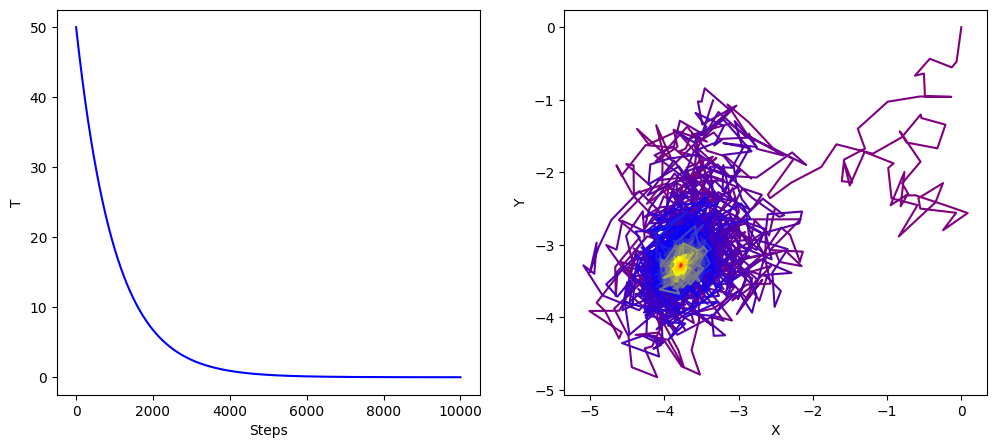

Final e: 0.0068910516388421125
Final xy: [-3.77406826 -3.27039804]


In [8]:
np.random.seed(2)
nstep = 10**4
results_sa = sa_geometric(n=2, func=f_Himmelblau, nstep=nstep, dx_max=0.5,
                       temp_max=50, scaling=0.999, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(results_sa['t'], color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('T')

for j in range(nseg):
    axes[1].plot(results_sa["x"][j*neach:(j+1)*neach,0], results_sa["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

final_e = results_sa['e'][-1]
final_xy = results_sa['x'][-1]

print("Final e:", final_e)
print("Final xy:", final_xy)

Acceptance rate: 0.2323


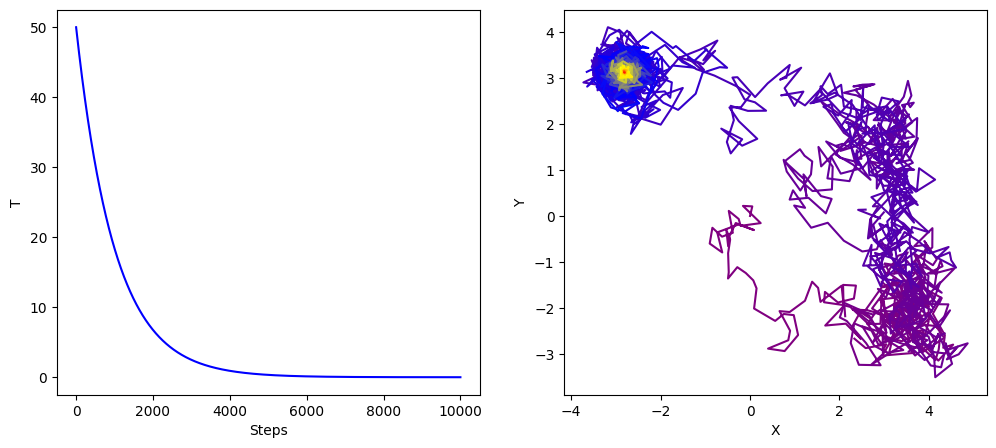

Final e: 0.0049799388211051124
Final xy: [-2.81191569  3.1221102 ]


In [9]:
np.random.seed(3)
nstep = 10**4
results_sa = sa_geometric(n=2, func=f_Himmelblau, nstep=nstep, dx_max=0.5,
                       temp_max=50, scaling=0.999, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(results_sa['t'], color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('T')

for j in range(nseg):
    axes[1].plot(results_sa["x"][j*neach:(j+1)*neach,0], results_sa["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

final_e = results_sa['e'][-1]
final_xy = results_sa['x'][-1]

print("Final e:", final_e)
print("Final xy:", final_xy)

Acceptance rate: 0.2424


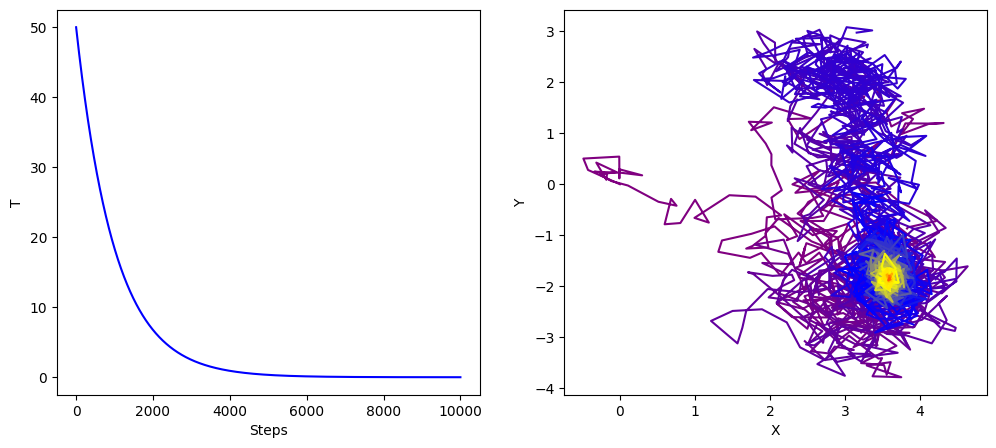

Final e: 0.00152640555526929
Final xy: [ 3.58885053 -1.84323505]


In [10]:
np.random.seed(7)
nstep = 10**4
results_sa = sa_geometric(n=2, func=f_Himmelblau, nstep=nstep, dx_max=0.5,
                       temp_max=50, scaling=0.999, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(results_sa['t'], color='blue')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('T')

for j in range(nseg):
    axes[1].plot(results_sa["x"][j*neach:(j+1)*neach,0], results_sa["x"][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

final_e = results_sa['e'][-1]
final_xy = results_sa['x'][-1]

print("Final e:", final_e)
print("Final xy:", final_xy)

Q: Could you think about other temperature updating schemes?

# Parallel tempering (aka Replica exchange)

Another enhanced sampling method is called parallel tempering (PT), also known as replica exchange. In the PA method, we set up a series of replicas, each corresponding to a fixed temperature. Within each replica, we perform a Metropolis-Hastings sampling of the Boltzmann distribution at the replica's temperature. We can choose the same or different temperatures for different replicas. A typical choice is to use replicas with high temperatures to cross landscape barriers (high $f$ values) and use replicas with low temperatures to explore local minima (low $f$ values).

Also, after certain steps of Metropolis-Hastings sampling for all replicas, we introduce a swapping of the coordinates $(x, y)$ of two replicas with a probability

$$a  = min(1, \frac{e^{-\frac{E_j}{T_i}}e^{-\frac{E_i}{T_j}}}{e^{-\frac{E_i}{T_i}}e^{-\frac{E_j}{T_j}}}) = min(1, e^{(E_i - E_j)(\frac{1}{T_i}-\frac{1}{T_j})}). \tag{3}$$

Such a swapping scheme satisfies detailed balance and ensures all replicas to sample the Boltzmann distributions at the right temperatures. (Q: how to prove this?) The swapping also allows the replicas with the lower temperatures to sample deep into the local minima and get "helps" from the replicas with higher temperatures to sample more states. 

### Two replicas

We first consider a total of two replicas. In the following implementation, the states ($x$) and scores ($e$) for both replicas are stored individually. 

In [11]:
def pt_2rep(n, func, x0, niter, nstep, dx_max, temp, ifprint=False):
    # n: number of variables
    # func: function to optimize func(x); x: vector of size n
    # x0: initial condition, matrix of dimension (n, 2)
    # niter: number of iterations 
    # nstep: number of steps in each iteration
    # dx_max: maximum step size (chosen from a uniform distribution), vector of size 2
    # temp: vector of size nrep, temperatures of all replica, vector of size 2
    # ifprint: logical, print messages (acceptance rate)
  
    x1 = np.zeros((niter*(nstep+1), n))
    x2 = np.zeros((niter*(nstep+1), n))
    e1 = np.zeros(niter*(nstep+1))
    e2 = np.zeros(niter*(nstep+1))
  
    x1[0, :] = x0[0, :]
    x2[0, :] = x0[1, :]
    num_accept = 0    # counting the number of accepted swaps
    rate_rep = np.zeros(2)  # computing the average acceptance rate for each replica
    for i in range(niter):
        start = i * (nstep + 1)
        end = (i + 1) * (nstep + 1)
    
        results_1 = mh(n, func, x1[start, :], nstep, dx_max=dx_max[0], temp=temp[0])
        results_2 = mh(n, func, x2[start, :], nstep, dx_max=dx_max[1], temp=temp[1])
      
        # save the sampling
        x1[start:end, :] = results_1['x']
        x2[start:end, :] = results_2['x']
        e1[start:end] = results_1['e']
        e2[start:end] = results_2['e']
    
        rate_rep[0] += results_1['rate']
        rate_rep[1] += results_2['rate']
    
        #check switching or not
        if i == niter - 1:
            break  # not for the last iteration
        a = np.exp((e1[end-1] - e2[end-1]) * (1/temp[0] - 1/temp[1]))
        if np.random.rand() < a:
            num_accept += 1
            x1[end, :] = x2[end-1, :]
            x2[end, :] = x1[end-1, :]
            e1[end] = e2[end-1]
            e2[end] = e1[end-1]
        else:
            x1[end, :] = x1[end-1, :]
            x2[end, :] = x2[end-1, :]
            e1[end] = e1[end-1]
            e2[end] = e2[end-1]
    
    if ifprint:
        print("Replica swapping acceptance rate:", num_accept/niter)
        print("Acceptance rate for each replica:", rate_rep/niter)
  
    return {'x1': x1, 'x2': x2, 'e1': e1, 'e2': e2}

We save the acceptance rate for both the replica swapping and the MH moves for each replica. These outputs help us to decide appropriate $dx_max$ for efficient MH sampling. In the test below, we set the temperatures of the two replica 10 and 50. The acceptance rate for the replica swapping is good (about 40%). However, when the temperatures become more different, the acceptance rate can significantly drop. In that case, more replicas are needed for more efficient sampling.

Replica swapping acceptance rate: 0.39
Acceptance rate for each replica: [0.3972 0.4876]


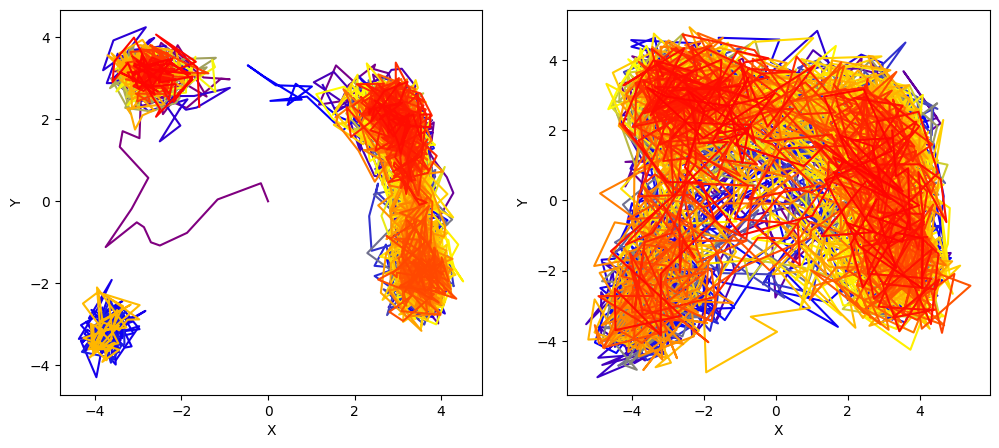

In [12]:
np.random.seed(1)
n = 2
x0 = np.zeros((2, n))
niter = 10**2
nstep = 10**2
dx_max = np.array([1, 2])
temp = np.array([10, 50])
nstep_tot = niter * (nstep+1)

results_pt = pt_2rep(n=n, func=f_Himmelblau, x0=x0, niter=niter,
                     nstep=nstep, dx_max=dx_max, temp=temp, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep_tot/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for j in range(nseg):
    axes[0].plot(results_pt['x1'][j*neach:(j+1)*neach,0], results_pt['x1'][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    
for j in range(nseg):
    axes[1].plot(results_pt['x2'][j*neach:(j+1)*neach,0], results_pt['x2'][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

plt.show()

### Multiple replicas

We generalize the previous PT implementation to allow more than two replicas. Here, we use R lists to save systems' states and *lapply* on the *mh* function for MH sampling of all replica {1, 2, ... $n_{rep}$}. We also set the temperatures $T_1 < T_2 < ... < T_{rep}$. Each replica undergoes the same number of MH sampling steps before replica swapping is allowed. There are also many different ways for replica swapping. For example, two replicas can be randomly selected for swapping. To improve the efficiency, we only allow the swapping between two adjacent replicas. To ensure ergodicity, we perform the swapping between 1 and 2, 3 an 4, *etc* in one round, and the swapping between 2 and 3, 4 and 5, *etc* in a second round.

In [13]:
import numpy as np

def pt_multi(n, func, x0, nrep, niter, nstep, dx_max, temp, ifprint=False):
    def mh_rep(ind):
        return mh(n, func, x[ind][start, :], nstep, dx_max=dx_max[ind], temp=temp[ind])

    x = [np.zeros((niter*(nstep+1), n)) for _ in range(nrep)]
    e = np.zeros((niter*(nstep+1), nrep))

    for i in range(nrep):
        x[i][0, :] = x0[i, :]

    num_accept = np.zeros(nrep - 1)
    num_proposed = np.zeros(nrep - 1)
    rate_rep = np.zeros(nrep)

    for i in range(1, niter + 1):
        start = (i - 1) * (nstep + 1)
        end = i * (nstep + 1)

        results = [mh_rep(j) for j in range(nrep)]

        for j in range(nrep):
            x[j][start:end, :] = results[j]['x']
            e[start:end, j] = results[j]['e']
            rate_rep[j] += results[j]['rate']

        if i == niter:
            break

        for j in range(nrep):
            x[j][end, :] = x[j][end - 1, :]
            e[end, j] = e[end - 1, j]

        if i % 2 == 1:
            j_seq = list(range(2, nrep, 2))
        else:
            j_seq = list(range(1, nrep, 2))

        for j in j_seq:
            num_proposed[j-1] += 1
            a = np.exp((e[end, j-1] - e[end, j]) * (1/temp[j-1] - 1/temp[j]))
            if np.random.rand() < a:
                num_accept[j-1] += 1
                x[j-1][end, :] = x[j][end - 1, :]
                x[j][end, :] = x[j-1][end - 1, :]
                e[end, j-1] = e[end, j]
                e[end, j] = e[end, j-1]

    if ifprint:
        print("Replica swapping acceptance rate:", num_accept / num_proposed)
        print("Acceptance rate for each replica:", rate_rep / niter)

    return {'x': x, 'e': e}


An application of the PT sampling.

Replica swapping acceptance rate: [0.55102041 0.62       0.69387755 0.64       0.65306122]
Acceptance rate for each replica: [0.5624 0.534  0.5394 0.5409 0.547  0.5199]


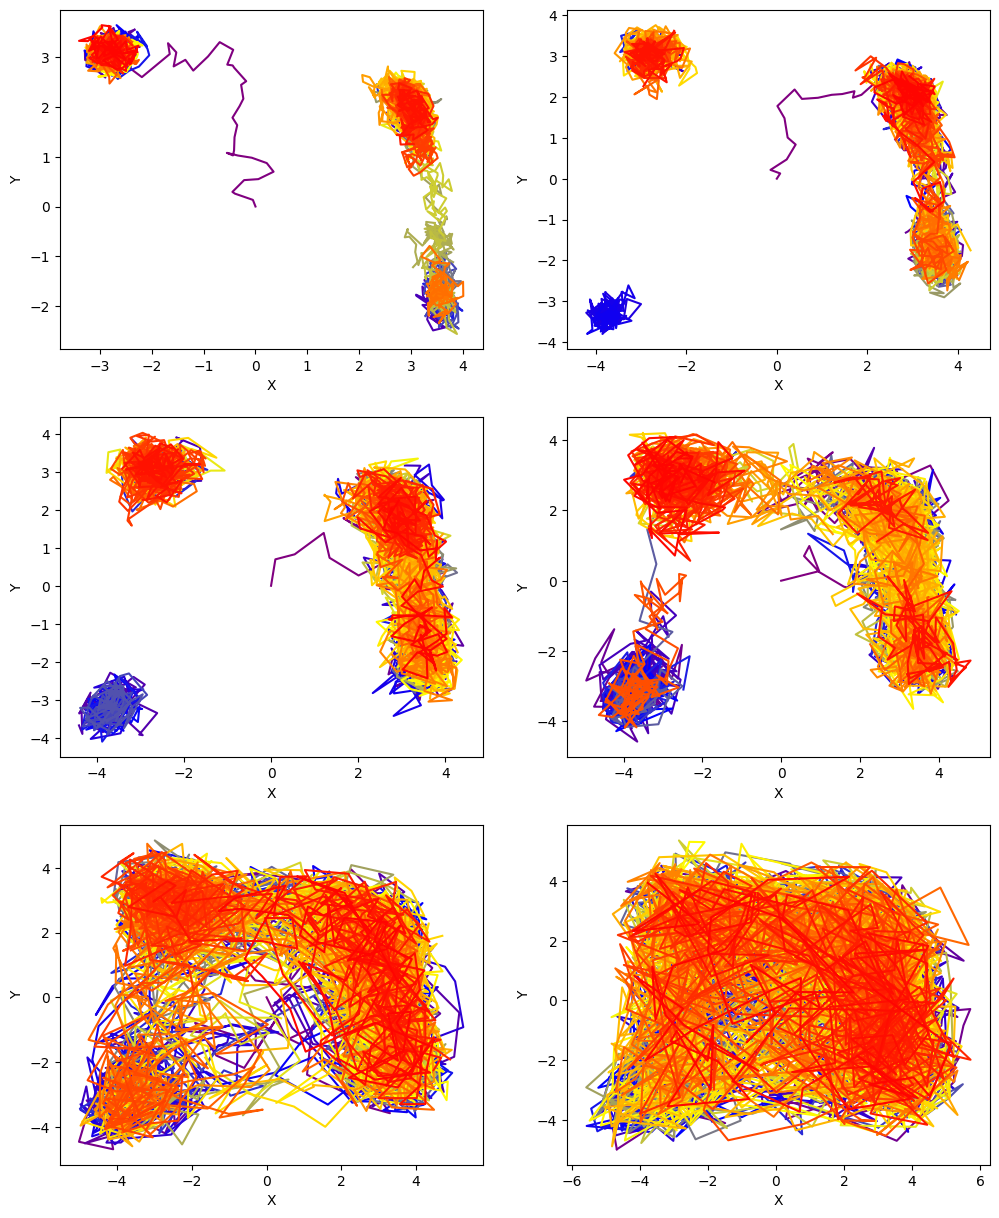

Mean energy per replica: [ 3.28416543  5.40742668 10.61256011 18.81777257 37.5794057  63.82404005]


In [14]:
np.random.seed(1)
n = 2
nrep = 6
x0 = np.zeros((nrep, n))
niter = 100
nstep = 100
dx_max = np.array([0.3, 0.5, 0.7, 1, 1.5, 2.5])
temp = np.array([2.3, 5, 10, 20, 40, 80])
nstep_tot = niter * (nstep + 1)

results_pt = pt_multi(n=n, func=f_Himmelblau, x0=x0, nrep=nrep, niter=niter,
                      nstep=nstep, dx_max=dx_max, temp=temp, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep_tot/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

for i in range(nrep):

    for j in range(nseg):
        axes[i//2, i%2].plot(results_pt['x'][i][j*neach:(j+1)*neach,0], results_pt['x'][i][j*neach:(j+1)*neach,1], c = colors[j])
    
        axes[i//2, i%2].set_xlabel('X')
        axes[i//2, i%2].set_ylabel('Y')

plt.show()

mean_energy_per_replica = np.mean(results_pt['e'], axis=0)
print("Mean energy per replica:", mean_energy_per_replica)

Below show the states sampled in different replicas.

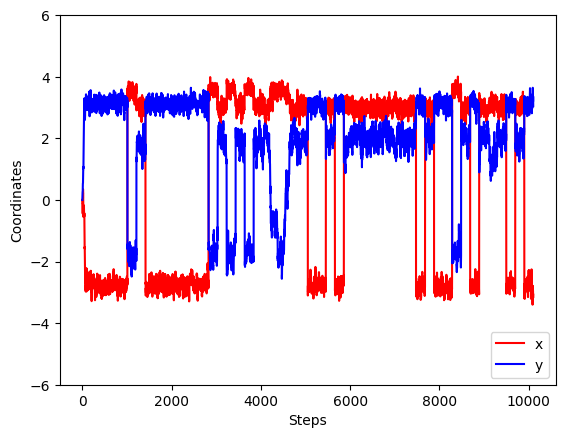

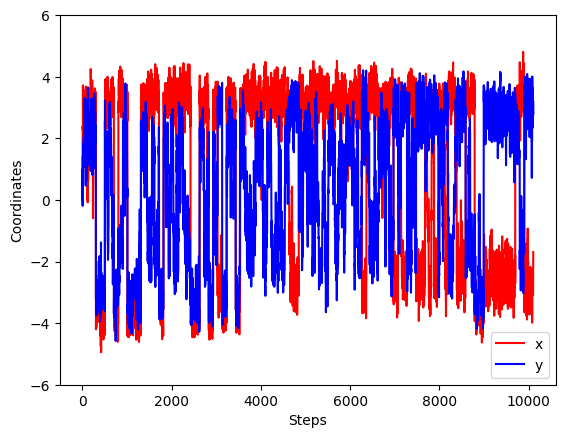

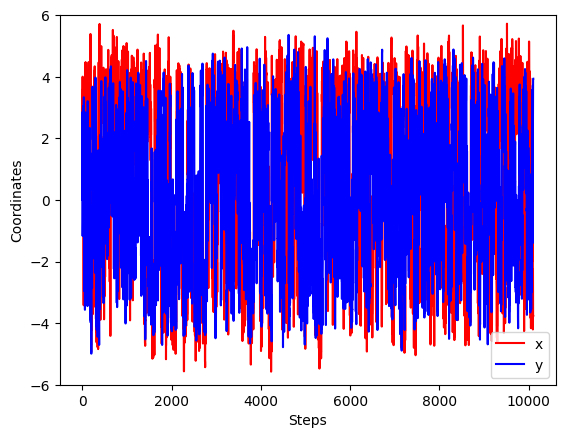

In [15]:
plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][0][:, 0], color='red', label='x')
plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][0][:, 1], color='blue', label='y')
plt.xlabel('Steps')
plt.ylabel('Coordinates')
plt.ylim(-6, 6)
plt.legend(loc='lower right')
plt.show()

plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][3][:, 0], color='red', label='x')
plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][3][:, 1], color='blue', label='y')
plt.xlabel('Steps')
plt.ylabel('Coordinates')
plt.ylim(-6, 6)
plt.legend(loc='lower right')
plt.show()

plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][5][:, 0], color='red', label='x')
plt.plot(np.arange(1, nstep_tot + 1), results_pt['x'][5][:, 1], color='blue', label='y')
plt.xlabel('Steps')
plt.ylabel('Coordinates')
plt.ylim(-6, 6)
plt.legend(loc='lower right')
plt.show()


# Simulated tempering

Lastly, we introduce another method called simulated tempering (ST). The method is in fact similar to simulated annealing in that the temperature also varies during the MCMC sampling. However, the ST method is more sophisticated, as it can properly sample the expected Boltzmann distributions at different temperatures in a single sampling trajectory (only one replica is needed).

In the ST method, the temperature of the system is sampled using MCMC among discrete user-defined temperature values $T_1 < T_2 < ... < T_{n_{temp}}$. We define a mixing parameter $\alpha$ to specify the ratio of Markov Chain moves that are devoted for the MH sampling under the same temperature or those that are devoted for MCMC sampling of the temperatures. When sampling the temperatures, we propose a move with 50% chance to increase the temperature to the next discrete level and 50% chance to decrease the temperature to the next discrete level. If the boundaries of the temperature values are reached, the temperature then remains at the boundary (for one of the 50% chances).

The proposed temperature move is accepted with the probability

$$a = min(1, \frac{c'}{c}e^{-E(\frac{1}{T'} - \frac{1}{T})}). \tag{4}$$
Here, $c$ are the weighting factors for each temperature level. If $c$ is set as the normalization factors of the Boltzmann distributions (*i.e.*, partition functions in statistical mechanics), different temperatures will be sampled with equal probability. $c$ is usually unknown, but we can set arbitrary values for an improved sampling (*e.g.*, larger $c$ for low temperatures to emphasize on the sampling under low temperatures). As usual, the notation $'$ denotes the proposed move. Below shows an implementation.

In [16]:
import numpy as np

def st(n, func, x0, nstep, alpha, dx_max, ntemp, temp_all, weight_all, ifprint=False):
    # n: number of variables
    # func: function to optimize func(x); x: vector of size n
    # x0: initial condition, vector of size n
    # nstep: number of steps in each iteration
    # alpha: mixing parameter (% of MCMC step v.s temperature step)
    # dx_max: maximum step size (chosen from a uniform distribution), vector of size nrep
    # ntemp : number of temperatures (T1 < T2 < T3 ... < Tntemp)
    # temp_all: vector of size ntemp, temperatures 
    # ifprint: logical, print messages (acceptance rate)
    
    x = np.zeros((nstep + 1, n))
    ind_t = np.zeros(nstep + 1, dtype=int)
    e = np.zeros(nstep + 1)

    x[0] = x0
    ind_t[0] = np.random.choice(ntemp)
    e[0] = func(x[0])
    
    num_accept = np.zeros(2)
    num_tot = np.zeros(2)

    for i in range(nstep):
        temp = temp_all[ind_t[i]]

        if np.random.rand() <= alpha:
            num_tot[0] += 1
            ind_t[i+1] = ind_t[i]
            dx = np.random.uniform(low=-dx_max, high=dx_max, size=n)
            xnew = x[i] + dx
            enew = func(xnew)
            de = enew - e[i]
            if de < 0 or np.random.rand() < np.exp(-de / temp):
                x[i+1] = xnew
                e[i+1] = enew
                num_accept[0] += 1
            else:
                x[i+1] = x[i]
                e[i+1] = e[i]
        else:
            num_tot[1] += 1
            if np.random.randint(2) == 0:
                ind_t_new = max(0, ind_t[i] - 1)
            else:
                ind_t_new = min(ind_t[i] + 1, ntemp-1)
            temp_new = temp_all[ind_t_new]
            if np.random.rand() < weight_all[ind_t_new] / weight_all[ind_t[i]] \
                    * np.exp(-e[i] * (1 / temp_new - 1 / temp)):
                ind_t[i+1] = ind_t_new
                x[i+1] = x[i]
                e[i+1] = e[i]
                num_accept[1] += 1
            else:
                ind_t[i+1] = ind_t[i]
                x[i+1] = x[i]
                e[i+1] = e[i]

    rate = num_accept / num_tot
    if ifprint:
        print("Acceptance rate:", rate)
    return {'x': x, 'e': e, 'ind_t': ind_t}


We consider 16 different temperature levels (from 5 to 80) and a set of weighting factors of decreasing values (from 5 to 1). As shown below, the ST method can properly sample multiple minima in a single sampling trajectory.

Q: How to obtain the details of local/global minima from the outputs of the ST?

Acceptance rate: [0.7024087  0.93844601]


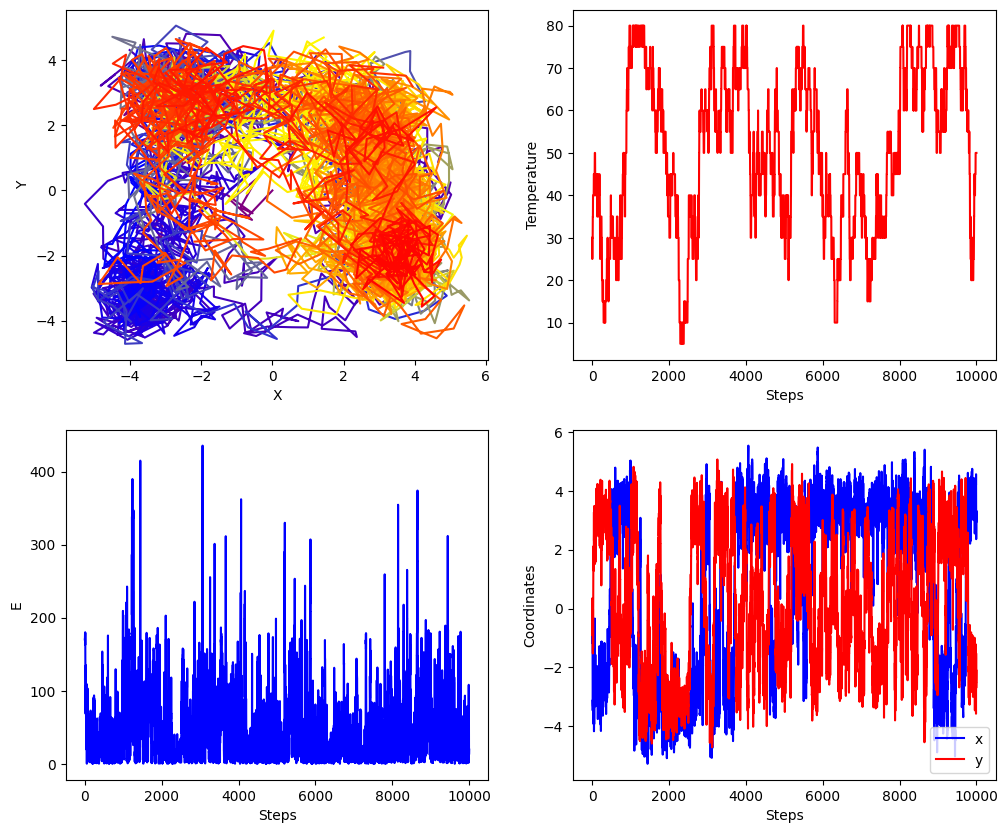

In [17]:
np.random.seed(1)
n = 2
x0 = np.zeros(n)
nstep = 10**4
alpha = 0.9
dx_max = 1
temp_all = np.arange(5, 81, 5)
ntemp = len(temp_all)
weight_all = np.arange(5, 0, -4 / (ntemp - 1))

results_st = st(n=n, func=f_Himmelblau, x0=x0, nstep=nstep, alpha=alpha, 
                dx_max=dx_max, ntemp=ntemp, temp_all=temp_all, 
                weight_all=weight_all, ifprint=True)

# Create a custom colormap 
nseg = 100 #100 line segments with changing colors
neach = int(nstep/nseg)
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['purple', 'blue', 'yellow', 'orange', 'red'])
colors = cmap(np.arange(nseg) / nseg)

# Create 2 subplots in a row
fig, axes = plt.subplots(2, 2, figsize=(12, 10))



for j in range(nseg):
    axes[0, 0].plot(results_st['x'][j*neach:(j+1)*neach,0], results_st['x'][j*neach:(j+1)*neach,1], c = colors[j])
    
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')


axes[0, 1].plot(np.arange(nstep + 1), temp_all[results_st['ind_t']], color='red')
axes[0, 1].set_xlabel('Steps')
axes[0, 1].set_ylabel('Temperature')

axes[1, 0].plot(np.arange(nstep + 1), results_st['e'], color='blue')
axes[1, 0].set_xlabel('Steps')
axes[1, 0].set_ylabel('E')

axes[1, 1].plot(np.arange(nstep + 1), results_st['x'][:, 0], color='blue', label='x')
axes[1, 1].plot(np.arange(nstep + 1), results_st['x'][:, 1], color='red', label='y')
axes[1, 1].set_xlabel('Steps')
axes[1, 1].set_ylabel('Coordinates')
axes[1, 1].legend(loc='lower right')

plt.show()